In [1]:
# Датасет mtg-jamendo 
#
# Клонировал репозиторий
#
# git clone https://github.com/MTG/mtg-jamendo-dataset.git
# cd mtg-jamendo-dataset
#
# Дальше создал среду, чтобы скачать один требуемый пакет
#
# uv init
# source .venv/bin/activate
# uv add gdown
#
# Затем скачал сам датасет
#
# python3 scripts/download/download.py --dataset autotagging_moodtheme --type audio-low ../mtg-jamendo-dataset/datasets --unpack --remove


# Аудиофайлы в датасете были с дополнительным .low перед .mp3 в названии
# Поэтому я переименовал все файлы убрав .low, чтобы названия полностью совпадали с таблицей c mood/theme

# import os

# _path = "../data/mtg-jamendo/audio/"
# for i in range(100):
    
#     path = _path + str(i).zfill(2)

#     for f in os.listdir(path):
#         old = os.path.join(path, f)
#         if os.path.isfile(old) and '.low.' in f:
#             new = os.path.join(path, f.replace('.low.', '.'))
#             os.rename(old, new)

In [2]:
# Этот датасет весит около 50гб, даже с выбранным низким качеством
# Поэтому я решил укоротить аудиофайлы до 30 секунд в рандомном месте вырезая этот самый 30 секундный кусок

# import os
# import librosa
# import soundfile as sf
# import random

# def cut_random_30s(input_dir, output_dir):
#     file_count = 0
#     for root, dirs, files in os.walk(input_dir):
#         for file in files:
#             if file.endswith(('.mp3', '.wav', '.flac')):
#                 input_path = os.path.join(root, file)
#                 relative_path = os.path.relpath(root, input_dir)
#                 output_subdir = os.path.join(output_dir, relative_path)
#                 os.makedirs(output_subdir, exist_ok=True)
                
#                 try:
#                     audio, sr = librosa.load(input_path, sr=None)
#                     total_duration = len(audio) / sr
                    
#                     if total_duration > 30:
#                         max_start = total_duration - 30
#                         start_time = random.uniform(0, max_start)
#                         start_sample = int(start_time * sr)
#                         end_sample = start_sample + 30 * sr
#                         audio_30s = audio[start_sample:end_sample]
#                     else:
#                         audio_30s = audio
                    
#                     output_path = os.path.join(output_subdir, file)
#                     sf.write(output_path, audio_30s, sr)
#                     file_count += 1
#                     print(f"Processed: {input_path}  {100 * file_count / len(files):.2f}%")
#                 except Exception as e:
#                     print(f"Error with {input_path}: {str(e)}")

# input_dir = "../data/mtg-jamendo/audio/"
# output_dir = "../data/temp/"
# for i in range(3, 100):
#     cut_random_30s(input_dir + str(i).zfill(2), output_dir + str(i).zfill(2))


# Теперь датасет весит 5.6гб, надеюсь обучение будет не слишком долгим (целых два с половиной часа ушло на урезание датасета...)


In [3]:
# # Теперь попробуем загрузить и визуализировать аудифайл

# import torchaudio
# import matplotlib.pyplot as plt
# import torch
# import librosa

# # Загрузил первый же аудиофайл
# waveform, sr = torchaudio.load("../data/train/00/95400.mp3")

# # Создал Mel-спектрограмму для более правдоподобной картины (для человеческого слуха)
# mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)

# # Человек воспринимает звук логарифмически если по-простому, поэтому логарифмируем, а потом преобразуем в numpy массив (матрицу), ибо matplotlib не воспринимает тензор
# data = mel_spectrogram.log2()[0,:,:].numpy()

# # Визуализация
# plt.figure(figsize=(16, 7))
# mel_freqs = librosa.mel_frequencies(n_mels=data.shape[0], fmin=0, fmax=sr/2)
# plt.imshow(data, cmap='viridis', origin='lower', aspect='auto',
#            extent=[0, data.shape[1], mel_freqs[0], mel_freqs[-1]])
# plt.colorbar(label='Громкость (dB)')
# plt.title("Mel-спектрограмма")
# plt.xlabel("Время (кадры)")
# plt.ylabel("Mel-банки")
# plt.show()

In [4]:
# # # через pandas никак не могу загрузить нормально файл (либо ошибка, либо обрезает теги), поэтому вручную построчно считываю
# import pickle

# data = []
# with open('../data/autotagging_moodtheme.tsv', 'r', encoding='utf-8') as f:
#     header = f.readline().strip().split('\t')
    
#     for line in f:
#         columns = line.strip().split('\t')
        
#         # Основные данные (первые 6 колонок)
#         track_data = {
#             'TRACK_ID': columns[0],
#             'ARTIST_ID': columns[1],
#             'ALBUM_ID': columns[2],
#             'PATH': columns[3],
#             'DURATION': float(columns[4]),
#             'tags': []
#         }
        
#         # Все остальные колонки - теги
#         for tag in columns[5:]:
#             if tag:  # если тег не пустой
#                 track_data['tags'].append(tag)
        
#         data.append(track_data)

# print(f"Прочитано {len(data)} треков")

# # И создам ещё словарь, который скорее всего сохраню, чтобы было удобнее потом работать с ним
# tracks = {}

# for item in data:
#     # track_id - это track_ + 7 цифр, цифры совпадают с названием аудифайла, но в id надо добавить нули до 7 цифр
#     # например название файла 7400.mp3, значит его id будет track_0007400
#     track_id = item['TRACK_ID']
#     mood_theme = set()
    
#     #избавляемся от ненужной приставки
#     for tag in item['tags']:
#         mood_theme.add(tag.replace('mood/theme---', ''))

#     #тут ещё поменял всем длительность, ибо вручную обрезал до 30 секунд все аудио
#     tracks[item['PATH']] = mood_theme

# print(f"Создано {len(tracks)} треков в словаре")
# print("Пример трека из словаря:")
# print(list(tracks.values())[30])

# #сохраняем на будущее
# # with open("../data/track_tags.pkl", 'wb') as f:
# #     pickle.dump(tracks, f)

# # для загрузки словаря
# with open("../data/track_tags.pkl", 'rb') as f:
#     tracks = pickle.load(f)

Теги и их количество: [('ambiental', 460), ('background', 496), ('space', 503), ('deep', 635), ('dream', 951), ('epic', 982), ('dark', 1202), ('relaxing', 1350)]
Всего тегов: 6579
Количество различных тегов: 8


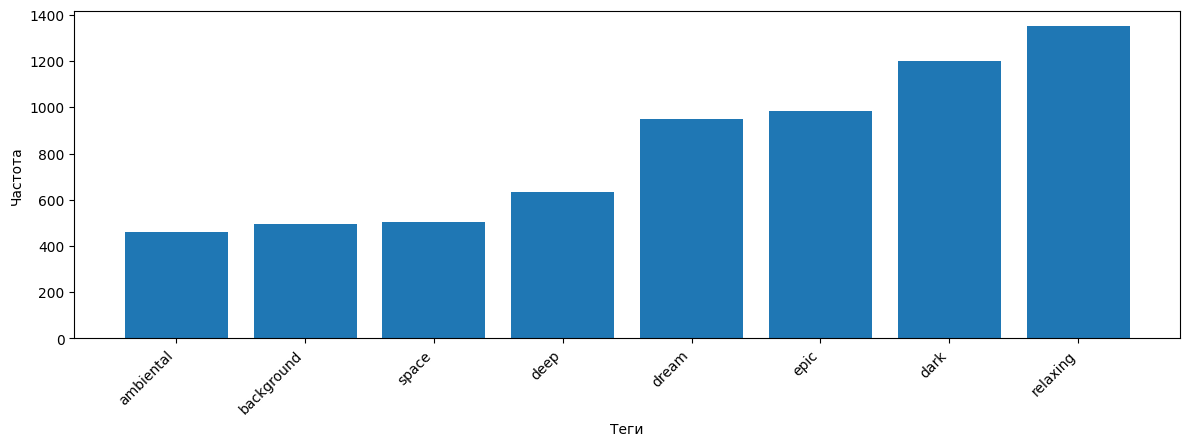

In [5]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import pickle

tracks = {}
moodthemes = {}

# открываем подготовленный словрь
with open("../data/tracks.pkl", 'rb') as f:
    tracks = pickle.load(f)

label_list = [
    'relaxing',
    'dark',
    'epic',
    'dream',
    'deep',
    'space',
    'background',
    'ambiental'
]
label_list = set(label_list)

# высчитываем количество каждого отдельного тега в датасете
for key, value in tracks.items():
    for tag in value["mood_theme"]:
        if tag in label_list:
            moodthemes.setdefault(tag, 0)
            moodthemes[tag] += 1

# общее количестов тегов
count = 0
for value in moodthemes.values():
    count += value



sorted_tags = sorted(moodthemes.items(), key=lambda x: x[1], reverse=False)
tags, counts = zip(*sorted_tags)

print(f"Теги и их количество: {sorted_tags}")
print(f"Всего тегов: {count}")
print(f"Количество различных тегов: {len(set(moodthemes.keys()))}")

# гистограмма тегов
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.bar(tags, counts) 
plt.xlabel('Теги')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

torch.Size([128, 7743])
7743
tensor([[-13.8155, -13.8155, -12.7456,  ..., -12.1595, -12.2506, -13.7235],
        [-13.8155, -13.8155, -13.1354,  ..., -12.9876, -13.3262, -13.7026],
        [-13.8155, -13.8155, -13.4251,  ..., -13.6919, -13.7526, -13.7988],
        ...,
        [-13.8155, -13.8155, -13.7121,  ..., -13.4789, -13.7301, -13.8141],
        [-13.8155, -13.8155, -13.7229,  ..., -13.5883, -13.7732, -13.8137],
        [-13.8155, -13.8155, -13.7816,  ..., -13.5077, -13.7429, -13.8126]])


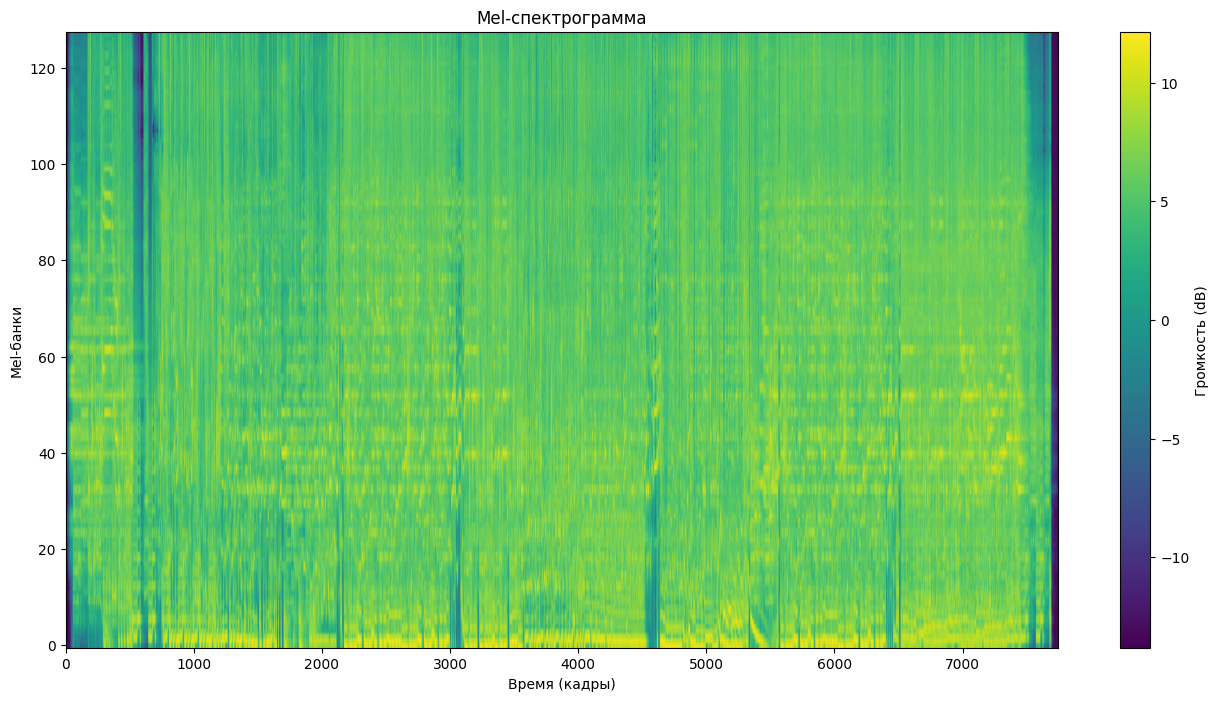

In [ ]:
import warnings
import random
import torchaudio
import matplotlib.pyplot as plt
import torch
import pickle

# убираем предупреждения
warnings.filterwarnings("ignore", message=".*TorchCodec.*")
warnings.filterwarnings("ignore", message=".*StreamingMediaDecoder.*")

#mel-спектрограмма
def spektr_view(mel_spektr):
    plt.figure(figsize=(16, 8))
    plt.imshow(mel_spektr[:,:].numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Громкость (dB)')
    plt.title("Mel-спектрограмма")
    plt.xlabel("Время (кадры)")
    plt.ylabel("Mel-банки")
    plt.show()

    # #waveform
    # plt.figure(figsize=(12, 4))
    # plt.plot(waveform[0].numpy())  # первый канал
    # plt.title("Waveform")
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.show()

# А вот уже и то с чем можно будет работать
def preprocess_audio(audio_path, target_sr = 22050, size=128) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_mels=128,        
        n_fft=2048,       
        hop_length=512,
        f_min=20,
        f_max=11025
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    return mel_spectrogram[0,:,:]
    
mel_spektr = preprocess_audio("/home/egr/Музыка/MAISONdes-Bake-no-Kawa.mp3")

print(mel_spektr.shape)
print(mel_spektr.shape[1])
print(mel_spektr)

spektr_view(mel_spektr)


In [ ]:
import os
import numpy as np
import pickle
import h5py
import gc

tags_dict = {}
# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as file:
    tags_dict = pickle.load(file)

def preprocess_entire_dataset_direct_save(data_dir, tracks_dict, size=128, save_path='../data/128x128.pth'):

    # Собираем все уникальные теги
    moodthemes = set()
    for tags in tracks_dict.values():
        moodthemes.update(tags)
    moodthemes = sorted(list(moodthemes))
    tag_to_idx = {tag: idx for idx, tag in enumerate(moodthemes)}
    num_classes = len(moodthemes)
    
    print(f"Found {num_classes} unique tags")
    print(f"Processing {len(tracks_dict)} audio files...")
    
    # Создаем HDF5 файл
    with h5py.File(save_path.replace('.pth', '.h5'), 'w') as f:
        # Создаем datasets с заранее неизвестным размером но с chunking
        spectrogram_dset = f.create_dataset(
            'spectrograms', 
            shape=(0, 1, 128, size),  # начнем с 0, будем resize
            maxshape=(None, 1, 128, size),
            chunks=(1000, 1, 128, size),
            dtype='float32'
        )
        
        labels_dset = f.create_dataset(
            'labels',
            shape=(0, num_classes),
            maxshape=(None, num_classes), 
            chunks=(1000, num_classes),
            dtype='float32'
        )
        
        processed_count = 0
        skipped_count = 0
        
        for i, (audio_path, tags) in enumerate(tracks_dict.items()):
            if i % 1000 == 0:
                print(f"Processing {i}/{len(tracks_dict)}...")
            
            try:
                full_audio_path = os.path.join(data_dir, audio_path)
                
                if not os.path.exists(full_audio_path):
                    skipped_count += 1
                    continue
                    
                # Используем ВАШУ функцию
                mel_spectrogram = preprocess_audio(full_audio_path)
                
                # Добавляем dimension для канала
                if len(mel_spectrogram.shape) == 2:
                    mel_spectrogram = mel_spectrogram.unsqueeze(0)
                
                # Multi-hot labels
                multi_hot = np.zeros(num_classes, dtype=np.float32)
                for tag in tags:
                    if tag in tag_to_idx:
                        multi_hot[tag_to_idx[tag]] = 1.0

                for i in range(int(mel_spectrogram.shape[1] / 128)):

                    # Расширяем datasets и добавляем данные
                    spectrogram_dset.resize(processed_count + 1, axis=0)
                    labels_dset.resize(processed_count + 1, axis=0)
                    
                    spectrogram_dset[processed_count] = mel_spectrogram.numpy()[:,i*size:size]
                    labels_dset[processed_count] = multi_hot
                
                    processed_count += 1
                
                    # Периодически сбрасываем на диск
                    if processed_count % 1000 == 0:
                        f.flush()
                        gc.collect()
                    
            except Exception as e:
                print(f"Error with {audio_path}: {e}")
                skipped_count += 1
                continue
        
        # Сохраняем метаданные как атрибуты
        f.attrs['class_names'] = np.array(moodthemes, dtype='S')  # сохраняем как bytes
        f.attrs['num_classes'] = num_classes
        
        print(f"\nSaved preprocessed dataset to {save_path.replace('.pth', '.h5')}")
        print(f"Total processed samples: {processed_count}")
        print(f"Skipped samples: {skipped_count}")
    
    return processed_count, skipped_count

#сохраняем подготовленный датасет в один файл
preprocess_entire_dataset_direct_save("../data/train", tags_dict)

Found 59 unique tags
Processing 18486 audio files...
Processing 0/18486...
Processing 1000/18486...
Processing 2000/18486...
Processing 3000/18486...
Processing 4000/18486...
Processing 5000/18486...
Processing 6000/18486...
Processing 7000/18486...
Processing 8000/18486...
Processing 9000/18486...
Processing 10000/18486...
Processing 11000/18486...
Processing 12000/18486...
Processing 13000/18486...
Processing 14000/18486...
Processing 15000/18486...
Processing 16000/18486...
Processing 17000/18486...
Processing 18000/18486...

Saved preprocessed dataset to ../data/128data.h5
Total processed samples: 18486
Skipped samples: 0


(18486, 0)

In [8]:
label_list = [
    'relaxing',
    'dark',
    'epic',
    'dream',
    'deep',
    'space',
    'background',
    'ambiental'
]
label_list = set(label_list)

track_dict = {}
# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as f:
    track_dict = pickle.load(f)

new_track_dict = {}

for key,values in track_dict.items():
    new_track_dict[key] = label_list.intersection(values)

print(f"Старый словарь: {len(track_dict)} \nНовый словарь: {len(new_track_dict)}")

with open("../data/8track.pkl", 'wb') as f:
    pickle.dump(new_track_dict, f)



Старый словарь: 18486 
Новый словарь: 18486
